<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import roc_auc_score as ras
from sklearn.metrics import f1_score as f1
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import (StratifiedShuffleSplit, GridSearchCV)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_columns', None)

In [2]:
def roc(features, target, model):
    pred_proba = model.predict_proba(features)
    proba_one = pred_proba[:, 1]
    print('roc_auc_score:', ras(target, proba_one))
    print('F1-score:', f1(target, model.predict(features)))

In [3]:
def roc_plot(model, x_test, y_test):
    proba_test = model.predict_proba(x_test)
    proba_one_test = proba_test[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, proba_one_test)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    

In [4]:
def split_data(features, target):
    x_train, x_test, y_train, y_test = train_test_split(features, target,
    test_size=0.2, random_state = 12345, stratify=target)


    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
    test_size=0.2, random_state= 12345, stratify=y_train)
    
    return x_train, y_train, x_test, y_test, x_val, y_val

In [5]:
def scale_data(x_train, x_valid, x_test, columns=['CreditScore', 'Age', 'Balance','Tenure', 'NumOfProducts', 'EstimatedSalary']):

    scaler = StandardScaler()
    
   # x_valid.columns = x_train.columns.astype(str)
   # x_test.columns = x_train.columns.astype(str)
   # x_train.columns = x_train.columns.astype(str)
    
    scaler.fit(x_train.loc[:, columns]) 
    
    x_train[columns] = scaler.transform(x_train.loc[:, columns])
    x_valid[columns] = scaler.transform(x_valid.loc[:, columns]) 
    x_test[columns]= scaler.transform(x_test.loc[:, columns])

    return x_train, x_valid, x_test


In [6]:
def top_params_rfc(x_train, y_train, x_valid, y_valid,balance=False, f1=f1, n_estim=range(10, 110, 10), min_samp_split=range(2, 11, 1), min_samp_leaf=range(2,11, 1), max_dph=range(6, 46, 3)):
    
    f1_max=0
    if balance==False:
        for n_est in n_estim:
            for min_spl in min_samp_split:
                for min_lf in min_samp_leaf:
                   # for max_d in max_dph:
                    rfc = RandomForestClassifier(random_state=12345, n_estimators=n_est, min_samples_split=min_spl, min_samples_leaf=min_lf)
                    rfc.fit(x_train, y_train)
                    f_local = f1(y_valid, rfc.predict(x_valid))
                    if f_local > f1_max:
                        f1_max = f_local
                        best_estimators = n_est
                        best_samples_split = min_spl
                        best_samples_leaf = min_lf
                        best_rfc = rfc
                      #  best_depth = max_d
                        if f1_max > 0.6:        
                            print('_______________________________________\n')
                            print(f'F1-score: {f1_max} на валидационной выборке')
                            print(f'F1-score: {f1(y_train, rfc.predict(x_train))} на тренировочной выборке')
                            print('\n')
                            print(f'estimator: {best_estimators}')
                            print(f'samples_split: {best_samples_split}')
                            print(f'samples_leaf: {best_samples_leaf}')
                            #print(f'max_depth: {best_depth}')
                            print('\n')
    else:
        
        for n_est in n_estim:
            for min_spl in min_samp_split:
                for min_lf in min_samp_leaf:
                   # for max_d in max_dph:
                    rfc = RandomForestClassifier(random_state=12345, n_estimators=n_est, min_samples_split=min_spl, min_samples_leaf=min_lf, class_weight='balanced')
                    rfc.fit(x_train, y_train)
                    f_local = f1(y_valid, rfc.predict(x_valid))
                    if f_local > f1_max:
                        f1_max = f_local
                        best_estimators = n_est
                        best_samples_split = min_spl
                        best_samples_leaf = min_lf
                        best_rfc = rfc
                      #  best_depth = max_d
                        if f1_max > 0.6:        
                            print('_______________________________________\n')
                            print(f'F1-score: {f1_max} на валидационной выборке (with_balance)')
                            print(f'F1-score: {f1(y_train, rfc.predict(x_train))} на тренировочной выборке (with_balance)')
                            print('\n')
                            print(f'estimator: {best_estimators}')
                            print(f'samples_split: {best_samples_split}')
                            print(f'samples_leaf: {best_samples_leaf}')
                            #print(f'max_depth: {best_depth}')
                            print('\n')

    return best_rfc, best_estimators, best_samples_split, best_samples_leaf #best_crit

In [7]:
def top_params_lr(x_train, y_train, x_valid, y_valid, f1=f1, pen=['l1', 'l2'], c_0_1=np.arange(0.1, 1.0, 0.1), balance=False):
    f1_max=0
    if balance==False:
        
        for p in pen:
            
            for c in (c_0_1):
                
                lr = LR(random_state=12345, penalty=p, C=c, solver='liblinear')
                lr.fit(x_train, y_train)
                f_local = f1(y_valid, lr.predict(x_valid))
                if f_local > f1_max:
                    f1_max = f_local
                    best_penalty = p
                    best_c = c
                    best_lr = lr
     
                    print('_______________________________________\n')
                    print(f'F1-score: {f1_max} на валидационной выборке')
                    print(f'F1-score: {f1(y_train, lr.predict(x_train))} на тренировочной выборке')
                    print('\n')
                    print(f'best_penalty: {best_penalty}')
                    print(f'best_c: {best_c}')                      
                    print('\n')
    else:
        for p in pen:
            for c in (c_0_1):
                lr = LR(random_state=12345, penalty=p, C=c, solver='liblinear', class_weight='balanced')
                lr.fit(x_train, y_train)
                f_local = f1(y_valid, lr.predict(x_valid))
                if f_local > f1_max:
                    f1_max = f_local
                    best_penalty = p
                    best_c = c
                    best_lr = lr
     
                    print('_______________________________________\n')
                    print(f'F1-score: {f1_max} на валидационной выборке (with_balance)')
                    print(f'F1-score: {f1(y_train, lr.predict(x_train))} на тренировочной выборке (with_balance)')
                    print('\n')
                    print(f'best_penalty: {best_penalty}')
                    print(f'best_c: {best_c}')                      
                    print('\n')
    return best_lr, best_penalty, best_c

In [8]:
def ohe_for_train(x_train, x_valid, x_test, y_train, y_valid, y_test, columns=['Geography', 'Gender'] ):
    
#    data = features.join(target, on=target.index)
 #   data_onehot = data.copy()
#    ohe = OneHotEncoder(drop = 'first', sparse = False)
#    for col in columns:
#        ohe = ohe.fit(data_onehot[[col]])
#        encoded_data = pd.DataFrame(ohe.transform(data_onehot[[col]]))
#        
#        encoded_data.columns = ohe.get_feature_names()
#        data_onehot = data_onehot.reset_index(drop=True)
#        data_onehot = pd.concat([data_onehot, encoded_data],axis=1)
#        data_onehot.drop(col, axis = 1, inplace = True)
#        x_train = data_onehot.drop('Exited', axis=1)
#        y_train = data_onehot['Exited']

    features = [x_train, x_valid, x_test]
    targets=[y_train, y_valid, y_test]
    
    
    data_train = features[0].join(targets[0], on=targets[0].index)
    data_valid = features[1].join(targets[1], on=targets[1].index)
    data_test = features[2].join(targets[2], on=targets[2].index)
    
    data_train_ohe = data_train.copy()
    data_valid_ohe = data_valid.copy()
    data_test_ohe = data_valid.copy()
    
    ohe = OneHotEncoder(drop = 'first', sparse = False)
    
    for col in columns:
        
        ohe.fit(data_train_ohe[[col]])
        
        encoded_train_data = pd.DataFrame(ohe.transform(data_train_ohe[[col]]))
        encoded_train_data.columns = ohe.get_feature_names()
        data_train_ohe = data_train_ohe.reset_index(drop=True)
        data_train_ohe = pd.concat([data_train_ohe, encoded_train_data],axis=1)
        data_train_ohe.drop(col, axis=1, inplace=True)
        
        encoded_valid_data = pd.DataFrame(ohe.transform(data_valid_ohe[[col]]))
        encoded_valid_data.columns = ohe.get_feature_names()
        data_valid_ohe = data_valid_ohe.reset_index(drop=True)
        data_valid_ohe = pd.concat([data_valid_ohe, encoded_valid_data],axis=1)
        data_valid_ohe.drop(col, axis=1, inplace=True)
        
        encoded_test_data = pd.DataFrame(ohe.transform(data_test_ohe[[col]]))
        encoded_test_data.columns = ohe.get_feature_names()
        data_test_ohe = data_test_ohe.reset_index(drop=True)
        data_test_ohe = pd.concat([data_test_ohe, encoded_test_data],axis=1)
        data_test_ohe.drop(col, axis=1, inplace=True)
        
        
    x_train = data_train_ohe.drop('Exited', axis=1)
    y_train = data_train_ohe['Exited']
    
    x_valid = data_valid_ohe.drop('Exited', axis=1)
    y_valid = data_valid_ohe['Exited']
    
    x_test = data_test_ohe.drop('Exited', axis=1)
    y_test = data_test_ohe['Exited']
           
    return x_train, y_train, x_valid, y_valid, x_test, y_test
        
  #features=[x_train, x_valid, x_test], targets=[y_train, y_valid, y_test], columns=['Geography', 'Gender']  

In [10]:
try: data = pd.read_csv(os.getcwd() + '\\Churn_Modelling.csv')
except: data = pd.read_csv('/datasets/Churn.csv')

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### Первые 3 фичи не несут смысловой нагрузки для обучения модели, их можно откинуть

In [11]:
data = data.iloc[:,3:]
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [12]:
data.shape

(10000, 11)

In [13]:
data.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

#### Готово

In [14]:
data = data.dropna(axis=0).reset_index(drop=True)

In [15]:
data.shape

(9091, 11)

#### Да, забыл про возраст, спасибо.

#### Готово. Не возможна в моём случае... Скину ссылку на статью: https://datastart.ru/blog/read/utechka-dannyh-v-machine-learning-kak-obnaruzhit-i-izbezhat-ee. Рекомендую ознакомиться...

## Исследование задачи

#### Exited - это наш целевой признак. На его основе будет решаться задача классификации путём обучения с учителем с помощью метода случайного леса деревьев (в дальнейшем буду называть его RFC).

In [18]:
ones = (data.loc[data['Exited']==1, :].shape[0] / data.shape[0]) * 100
zeros = (data.loc[data['Exited']==0, :].shape[0] / data.shape[0]) * 100

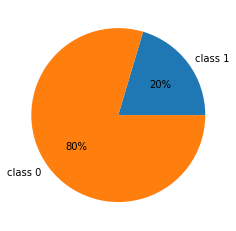

In [19]:
shape_classes = [ones, zeros]
labels = ['class 1', 'class 0']
plt.pie(shape_classes, labels = labels, autopct='%.0f%%')
plt.show()

In [20]:
x_train, y_train, x_test, y_test, x_valid, y_valid = split_data(data.drop(columns='Exited'), data['Exited'])
x_train, x_valid, x_test = scale_data(x_train, x_valid, x_test)
x_train, y_train, x_valid, y_valid, x_test, y_test = ohe_for_train(x_train, x_valid, x_test, y_train, y_valid, y_test, columns=['Geography', 'Gender'])

#### В качестве первой модели возьмём RandomForestClassifier, так же обучим модель без гиперпараметров и с ними, чтобы показать разницу

In [21]:
%%time

rfc = RandomForestClassifier(random_state=12345)
rfc.fit(x_train, y_train)

CPU times: user 542 ms, sys: 18.7 ms, total: 560 ms
Wall time: 565 ms


RandomForestClassifier(random_state=12345)

roc_auc_score: 0.859918994202241
F1-score: 0.569620253164557


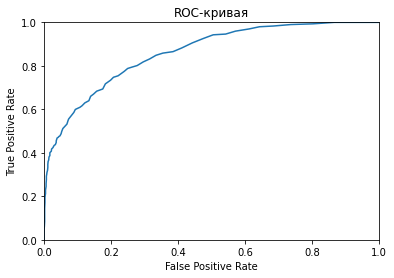

In [22]:
roc(x_valid, y_valid, rfc)
roc_plot(rfc, x_valid, y_valid)

#### Для сравнения поберём гиперпармаетры для RFC:

roc_auc_score: 0.8671894535452394
F1-score: 0.5970149253731344


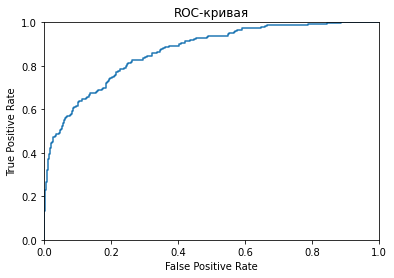

CPU times: user 3min 53s, sys: 912 ms, total: 3min 54s
Wall time: 3min 54s


In [23]:
%%time

best_rfc, best_estimators, best_samples_split, best_samples_leaf = top_params_rfc(x_train, y_train, x_valid, y_valid)



roc(x_valid, y_valid, best_rfc)
roc_plot(best_rfc, x_valid, y_valid)

#### В качестве второй модели возьмём LogisticRegression и так же обучим модель без гиперпараметров и с ними, чтобы показать разницу

roc_auc_score: 0.7644609596250356
F1-score: 0.2914572864321608


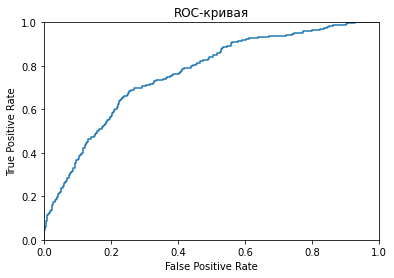

CPU times: user 231 ms, sys: 252 ms, total: 483 ms
Wall time: 486 ms


In [24]:
%%time
lr = LR(random_state=12345)
lr.fit(x_train, y_train)



roc(x_valid,y_valid, lr)
roc_plot(lr, x_valid, y_valid)

_______________________________________

F1-score: 0.2864450127877238 на валидационной выборке
F1-score: 0.28405422853453843 на тренировочной выборке


best_penalty: l1
best_c: 0.1


_______________________________________

F1-score: 0.28787878787878785 на валидационной выборке
F1-score: 0.29389312977099236 на тренировочной выборке


best_penalty: l1
best_c: 0.5


_______________________________________

F1-score: 0.2914572864321608 на валидационной выборке
F1-score: 0.29516539440203565 на тренировочной выборке


best_penalty: l2
best_c: 0.5


roc_auc_score: 0.7645132964649373
F1-score: 0.2914572864321608


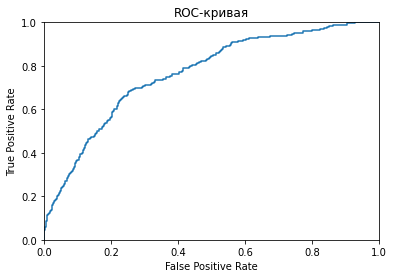

CPU times: user 655 ms, sys: 1.33 s, total: 1.99 s
Wall time: 2.01 s


In [25]:
%%time
best_lr, best_penalty, best_c = top_params_lr(x_train, y_train, x_valid, y_valid)
roc(x_valid,y_valid, best_lr)
roc_plot(best_lr, x_valid, y_valid)

#### Метрика F1 модели LR не высока, возможно это связано с дизбалансом.

#### Вывод: RFC - стала победителем в двух метриках. Касательно самих метрик: можно и лучше. Очевидная нехватка борьбы с дисбалансом

## Борьба с дисбалансом

In [26]:
data.loc[data['Exited']==1,:].shape

(1854, 11)

In [27]:
data.loc[data['Exited']==0,:].shape

(7237, 11)

#### Дизбаланс очевиден

#### Метод повышения размерности.

In [28]:
def upsample(train, target, repeat=4):
    
    data = train.join(target, on=target.index)
    zero = data[data['Exited']==0]
    one = data[data['Exited']==1]
    
    result = pd.concat([zero] + [one] * repeat)
    result = shuffle(
    result, random_state=12345)
    train = result.drop(columns='Exited')
    target = result['Exited']
    
    return train, target

#### Помимо метода повышения размерности - есть ещё и метод понижения.

In [29]:
def downsample(train, target, fraction=0.3):

    
    data = train.join(target, on=target.index)
    zero = data[data['Exited']==0]

    one = data[data['Exited']==1]

    result = pd.concat(
    [zero.sample(frac=fraction, random_state=12345)] + [one])
    
    result = shuffle(result, random_state=12345)
    train = result.drop(columns='Exited')
    target = result['Exited']
    
    return train, target

In [30]:
x_train, y_train, x_test, y_test, x_valid, y_valid = split_data(data.drop(columns='Exited'), data['Exited'])
x_train, x_valid, x_test = scale_data(x_train, x_valid, x_test)
x_train, y_train, x_valid, y_valid, x_test, y_test = ohe_for_train(x_train, x_valid, x_test, y_train, y_valid, y_test, columns=['Geography', 'Gender'])

#### Метод повышения размерности в действии

In [31]:
x_train_up, y_train_up = upsample(x_train, y_train)

In [32]:
y_train.value_counts()

0    4631
1    1186
Name: Exited, dtype: int64

In [33]:
y_train_up.value_counts()

1    4744
0    4631
Name: Exited, dtype: int64

#### С помощью upsample повысил размерность класса 1

#### Начнём с RFC

In [34]:
%%time

best_rfc_up, best_estimators, best_samples_split, best_samples_leaf = top_params_rfc(x_train_up, y_train_up, x_valid, y_valid)

_______________________________________

F1-score: 0.6033333333333334 на валидационной выборке
F1-score: 0.9863811206986173 на тренировочной выборке


estimator: 10
samples_split: 6
samples_leaf: 2


_______________________________________

F1-score: 0.617124394184168 на валидационной выборке
F1-score: 0.9839261640568288 на тренировочной выборке


estimator: 20
samples_split: 2
samples_leaf: 3


_______________________________________

F1-score: 0.6210045662100456 на валидационной выборке
F1-score: 0.95296775518587 на тренировочной выборке


estimator: 30
samples_split: 2
samples_leaf: 6


_______________________________________

F1-score: 0.6222222222222223 на валидационной выборке
F1-score: 0.9068115336397827 на тренировочной выборке


estimator: 30
samples_split: 2
samples_leaf: 10


_______________________________________

F1-score: 0.6259314456035767 на валидационной выборке
F1-score: 0.9127405096203849 на тренировочной выборке


estimator: 100
samples_split: 2
samples_leaf: 10




roc_auc_score: 0.8750894087681653
F1-score: 0.6259314456035767


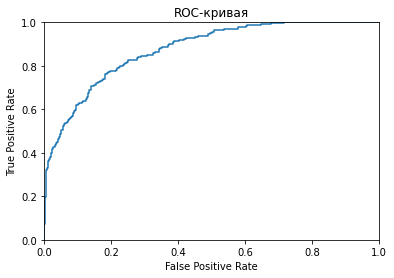

In [35]:
roc(x_valid,y_valid, best_rfc_up)
roc_plot(best_rfc_up, x_valid, y_valid)

#### Для сравнения возьмём LR

In [36]:
%%time

best_lr_up, best_penalty, best_c = top_params_lr(x_train_up, y_train_up, x_valid, y_valid)

_______________________________________

F1-score: 0.5029239766081871 на валидационной выборке
F1-score: 0.7084306646846464 на тренировочной выборке


best_penalty: l1
best_c: 0.1


CPU times: user 860 ms, sys: 1.86 s, total: 2.72 s
Wall time: 2.72 s


roc_auc_score: 0.7680954623959806
F1-score: 0.5029239766081871


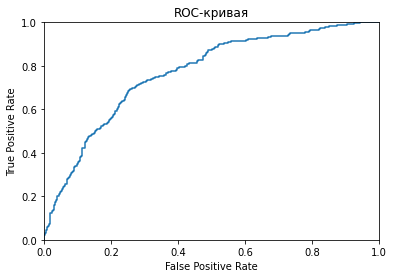

In [37]:
roc(x_valid,y_valid, best_lr_up)
roc_plot(best_lr_up, x_valid, y_valid)

#### Метод понижения размерности:

In [38]:
x_train_down, y_train_down = downsample(x_train, y_train, fraction=0.3)

In [39]:
y_train_down.value_counts()

0    1389
1    1186
Name: Exited, dtype: int64

In [40]:
y_train.shape

(5817,)

In [ ]:
%%time

best_rfc_down, best_estimators, best_samples_split, best_samples_leaf = top_params_rfc(x_train_down, y_train_down, x_valid, y_valid)
roc(x_valid,y_valid, best_rfc_down)
roc_plot(best_rfc_down, x_valid, y_valid)


_______________________________________

F1-score: 0.6036161335187762 на валидационной выборке
F1-score: 0.8662309368191722 на тренировочной выборке


estimator: 20
samples_split: 2
samples_leaf: 5


_______________________________________

F1-score: 0.6082036775106081 на валидационной выборке
F1-score: 0.8492307692307692 на тренировочной выборке


estimator: 30
samples_split: 2
samples_leaf: 6


_______________________________________

F1-score: 0.6100278551532033 на валидационной выборке
F1-score: 0.9334485738980121 на тренировочной выборке


estimator: 30
samples_split: 7
samples_leaf: 2




In [ ]:
%%time


best_lr_down, best_penalty, best_c = top_params_lr(x_train_down, y_train_down, x_valid, y_valid)
print('\n')
roc(x_valid, y_valid, best_lr_down)
roc_plot(best_lr_down, x_valid, y_valid)

#### Способ №2. Балансировка

In [ ]:
%%time
print('RFC включая взвешивание классов и подбор гиперпараметров: ')

best_rfc_balance, best_estimators, best_samples_split, best_samples_leaf = top_params_rfc(x_train, y_train, x_valid, y_valid, balance=True)

In [ ]:
roc(x_valid, y_valid, best_rfc_balance)
roc_plot(best_rfc_balance, x_valid, y_valid)

In [ ]:
%%time
print('LR включая взвешивание классов и подбор гиперпараметров: ')

best_lr_balance, best_balance, best_balance = top_params_lr(x_train, y_train, x_valid, y_valid, balance=True)
roc(x_valid, y_valid, best_lr_balance)
roc_plot(best_lr_balance, x_valid, y_valid)

#### Вывод: метод взешивания классов для нашей задачи наиболее эффективный, особенно в совокупности с подбором гиперпараметров и RFC

## Тестирование модели

In [ ]:
roc(x_test, y_test, best_rfc_balance)
roc_plot(best_rfc_balance, x_test, y_test)

### Вывод: качество заметно улучшилось, благодаря тому, что дизбаланс классов был более менее выровнен, проведена стандартизация (для LR), а так же произведён поиск гипер параметров. Однако наиболее эффектинвым способом для данной задачи сдал метод взвешивания классов. Улучшение отчётливо видно на наших метрика (roc_auc_score и F1-score).

# Общий вывод: После загрузки данных были откинуты ненужные фичи. Так же проведена работа с пропусками. Далее применён метод OneHotEncoder для кодирования строкового представления в цифровое. Затем написал функции для деления выборки на тренировочную, валидационную и тестовую для обучения моделей и стандартизации разделённых данных. А так же ещё две функции. Первая выводит roc_auc_score на основании вероятностей и F1-score, вторая же функция строит график на основании вероятностей и roc_auc_score. После чего обучил две модели random_forest_classifier и LogisticRegression. Касательно RFC: подбор улучшил наши метрики. Далее привёл 3 способа борьбы с дизбалансом: 1-ый - Upsample, 2-ой - Downsample и 3-ий - это взвешивание классов. Остановился на взвешивании классов, т.к.  метрики дали хороший результат. 